# Person - forecasting

The purpose here is to generate the most accurate hourly forecast given a set of data points with collected and engineered features.

### TODO:
Add cross validation instead of only train/test split.

In [179]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load dataset

In [180]:
filename = '../Datasets/Person_features__2019-09-09_2020-03-02.pickle'
infile = open(filename,'rb')
(numerical, dummies, cyclical, raw_data), y = pickle.load(infile)
infile.close()

### Load best features

We have saved the best features in the FeatureSelection Notebook, however I have realised that 

In [209]:
best_filename = '../Datasets/Person_best_features__2019-09-09_2020-03-02.pickle'
infile = open(best_filename,'rb')
best_k_features_list, best_feat_importances = pickle.load(infile)
infile.close()

### Comment on data volume

The data covers 6 months of collected images and we have 4140 hourly object counts for analysis.

Unfortunately to see the full seasonality on the dataset, it would be beneficial to have a full year (or ideally even 2 years) of data, which would increase the likelyhood of producing more accurate forecast.

Especially when Neural Networks were used, I have observed that they very quickly overfit the data, and therefore a very simple architecture and additional layers to prevent overfitting were used.

### Verify targets

Verify that the outliers have been handled and higher counts have been capped

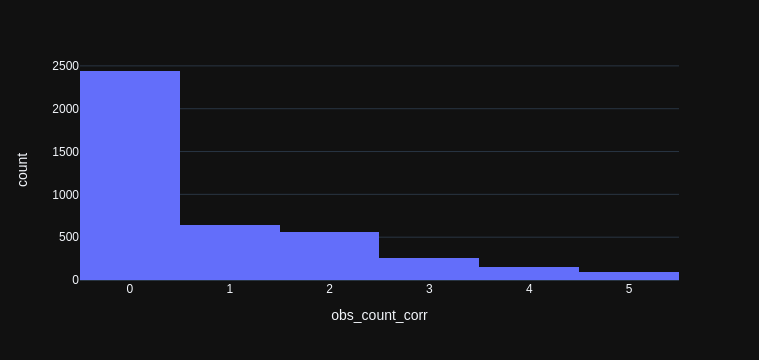

In [10]:
px.histogram(raw_data, x="obs_count_corr", height=300, width=600, nbins=6)

### Filter out nightly hours dilemma

For now I am making a decision to include the night-time hours.

But this can be changed based on the following fact: Current data collection and specifically lack of a night vision camera drives all nightly observations to pretty much 0.

If we wanted to, we could use the daily sunrise and sunset time to exclude only relevant data points, instead of blindly removing too much data. This code snippet could do this for us:

```python
# convert timestamps to hours
conv_ts = lambda x: datetime.fromtimestamp(x).hour
df['sunrise_hour'] = df['daily__sunriseTime'].apply(conv_ts)
df['sunset_hour'] = df['daily__sunsetTime'].apply(conv_ts)

# remove nightly records
idx = (df['hour'] < df['sunrise_hour']) | (df['hour'] > df['sunset_hour'])
df = df.loc[~idx]
```

It might be a good idea to revisit this when deciding on the final model to use

### Error analysis plot/outputs

In [11]:
error_tracker = {}
def analyse_error(y_test, y_pred, model_name, show_plot=True):    
    df = pd.DataFrame()
    df['obs_count_corr'] = y_test
    df['predicted'] = y_pred
    df['abs_error'] = (df['obs_count_corr'] - df['predicted']).abs()
    total_abs_error = df['abs_error'].sum()  ##
    idx = df['abs_error'] == 0
    total_corr_samples = df[idx].shape[0]  ##
    total_samples = df.shape[0]  ##
    acc = round(df[idx].shape[0] / df.shape[0], 2)  ##
    idx_total = (df['obs_count_corr'] > 0)
    idx_total_correct = (df['obs_count_corr'] > 0) & (df['abs_error'] == 0)
    acc_not_zero_count = round(df[idx_total_correct].shape[0] / df[idx_total].shape[0], 2)  ##
    idx = df['abs_error'] > 0
    error_tracker[model_name] = {
        'total_samples': total_samples,
        'total_abs_error': total_abs_error,
        'total_corr_samples': total_corr_samples,
        'acc': acc,
        'acc_not_zero_count': acc_not_zero_count,
        'mae': round(df['abs_error'].mean(), 2),
        'mse': round(np.mean((df['obs_count_corr'] - df['predicted']) ** 2), 2)
    }
    if show_plot:
        df['raw_error'] = df['obs_count_corr'] - df['predicted']
        fig = px.histogram(df, x="raw_error", opacity=0.7, height=325, width=800,
                           nbins=8, title=f'Raw error distribution for {model_name} Model')
        fig.show()
        #fig = px.histogram(df, x="abs_error", opacity=0.7, height=325, width=800,
        #                   nbins=8, title=f'Absolute error distribution for {model_name} Model')
        #fig.show()
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=y_test.tolist()[:150], mode='lines', name='True', opacity=0.7))
        fig.add_trace(go.Scatter(y=y_pred.tolist()[:150], mode='lines', name='Predicted', opacity=0.7))
        fig.update_layout(title='True vs Predicted counts', height=375)
        fig.show()

### Baseline simple model (without Machine Learning)

Firstly - create a crude model, which will use hourly averages to generate a forecast.

Even though this model is very simplistic, it is actually quite robust, very fast to execute and easy to explain.

In [124]:
# create a train/test split for the dataset
X = raw_data[['hour', 'obs_count_corr']]
y = raw_data['obs_count_corr']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=41)

In [125]:
# calculate hourly averages of counts for training set
mean_obj_counts = X_train.groupby('hour')['obs_count_corr'].mean()

In [126]:
# now we can generate the predictions for the test set
y_pred = X_test['hour'].map(mean_obj_counts)

In [127]:
# round results
y_pred_rounded = np.array([round(p) for p in y_pred])

In [128]:
# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

mse: 1.0521739130434782
mae 0.5922705314009662


Even though the mean squared error is a good metric to utilise in the analytical framework (high errors should be penalised more), it is easier to interpret the mean absolute error in a visual mode.

Errors are calculated as:

$$meanAbsoluteError=\frac{1}{n}\sum_{i=1}^{n}|true-predicted|$$
$$meanSquaredError=\frac{1}{n}\sum_{i=1}^{n}(true-predicted)^2$$

Histogram below shows the magnitute of raw mistakes made by the model (undercalling and overcalling). The goal is to maximise the middle piece, which represents no errors.

Next, we will also plot a sample 150 predicted data points vs the actual counts to see how far off the predictions are.

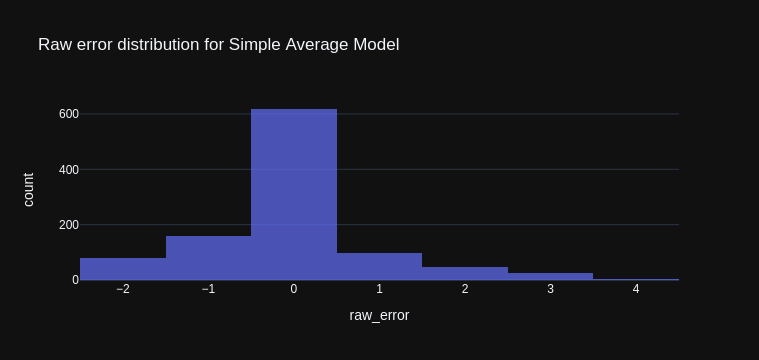

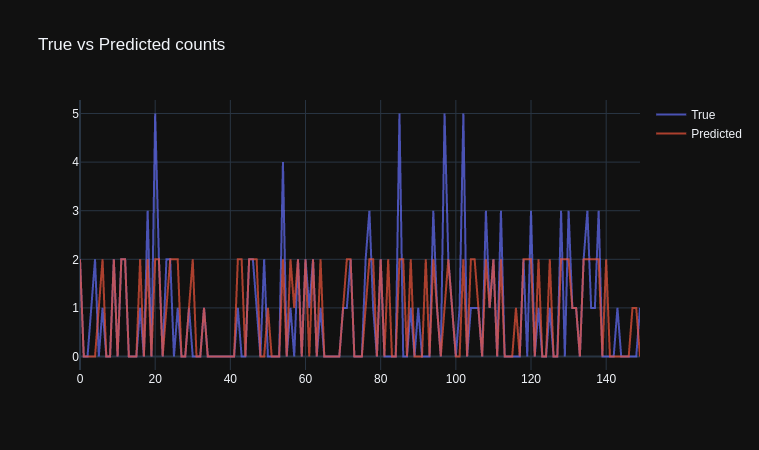

{'total_samples': 1035, 'total_abs_error': 613, 'total_corr_samples': 618, 'acc': 0.6, 'acc_not_zero_count': 0.33, 'mae': 0.59, 'mse': 1.05}


In [17]:
analyse_error(y_test, y_pred_rounded, 'Simple Average')
print(error_tracker['Simple Average'])

### Prepare X and y

- define X and y
- split into traning and testing
- scale data

In [129]:
# handy utility function to merge multiple dataframes
def merge_datasets(datasets):
    """
    Usages:
    - merge_datasets([numerical, dummies, cyclical])
    - merge_datasets([dummies, cyclical])
    - merge_datasets([numerical, dummies])
    """
    df = datasets[0].copy()
    for d_next in datasets[1:]:
        df = df.merge(d_next, left_index=True, right_index=True)
    return df

### Machine Learning linear model (Linear Regression)

Following code snippet tries a simple least squares model (LSM) to predict the object counts. I have verified that it scores a better result when less features are passed into it.

The `best_k_features_list` achieves the best result.

In [213]:
from sklearn.linear_model import LinearRegression

merged_dataset = merge_datasets([numerical, dummies, cyclical])

# best_k_features_list
# best_feat_importances

# create dataset by merging all features
X = merged_dataset[best_k_features_list]
y = raw_data['obs_count_corr']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create and fit the model
model = LinearRegression(n_jobs=6)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = np.array([int(round(p)) for p in y_pred])

# calculate scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae:', mean_absolute_error(y_test, y_pred_rounded))

# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print('true:', y_test[:10].tolist())
print('pred:', y_pred_rounded[:10].tolist())

mse: 1.0502415458937198
mae: 0.6096618357487923
true: [3, 0, 0, 4, 2, 0, 2, 1, 0, 1]
pred: [2, 0, 0, 2, 2, 0, 1, 1, 0, 0]


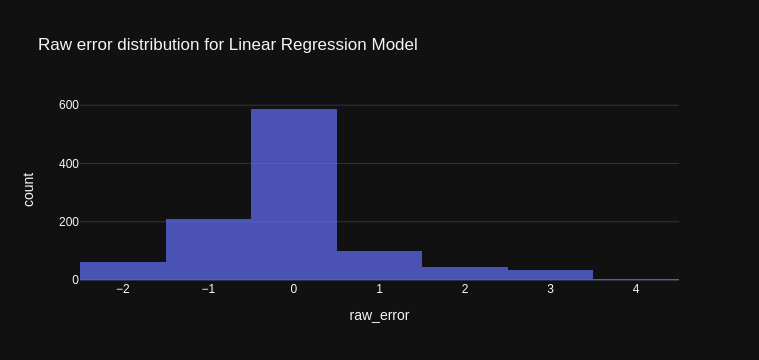

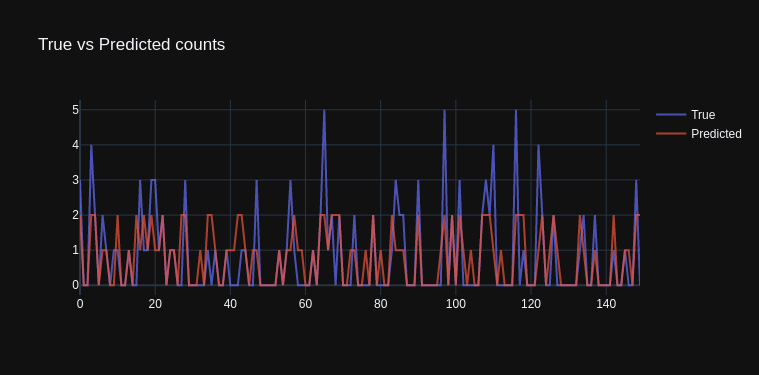

{'total_samples': 1035, 'total_abs_error': 631, 'total_corr_samples': 587, 'acc': 0.57, 'acc_not_zero_count': 0.41, 'mae': 0.61, 'mse': 1.05}


In [214]:
analyse_error(y_test, y_pred_rounded, 'Linear Regression')
print(error_tracker['Linear Regression'])

### Verify scores with cross validation

Verify if the result above was obtained due to the random data split, and train on the whole data using Cross Validation folds.

In [215]:
# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = LinearRegression(n_jobs=6)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))


mean mse: 1.0495169082125604
mean mae: 0.6166666666666667


#### Commentary

As can be seen above, Linear Regression model has a worse Mean Absolute Error in comparison to the simple averaging model, however achieves much higher accuracy on the non-zero observations, meaning observations, which has 1 or more objects counted. It's also a simple enough model to explain and very fast to execute, so it should not be underestimated.

### Random Forest model

Following code snippet uses a more complex algorithm (Random Forest), which is more capable to  pick up more complex relationships between features and the target and improve the baseline model.

After testing with multiple feature sets, it turned out that merging the K-Best features with features with highest importance reduces the error the most.

In [216]:
from sklearn.ensemble import RandomForestRegressor

In [220]:
# create dataset by merging all features
merged_dataset = merge_datasets([numerical, dummies, cyclical])

# best_k_features_list
# best_feat_importances
# join 2 sets of best features
unique_features = list(set(best_k_features_list + best_feat_importances))

# create dataset by merging all features
X = merged_dataset[unique_features]
y = raw_data['obs_count_corr']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit model and make predictions
model = RandomForestRegressor(n_estimators=300, criterion='mse', n_jobs=6)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# round results to nearest int
y_pred_rounded = np.array([int(round(p)) for p in y_pred])

print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print('true:', y_test[:10].tolist())
print('pred:', y_pred_rounded[:10].tolist())

mse: 0.9903381642512077
mae 0.5768115942028985
true: [3, 0, 0, 4, 2, 0, 2, 1, 0, 1]
pred: [2, 0, 0, 2, 2, 0, 1, 0, 0, 0]


As we can see, based on the output above - Random Forest does a better job at predicting the counts than the Linear Regression model, as it's predictive power is much higher.

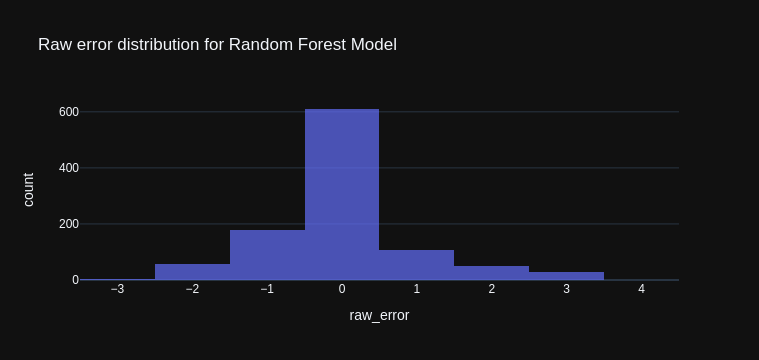

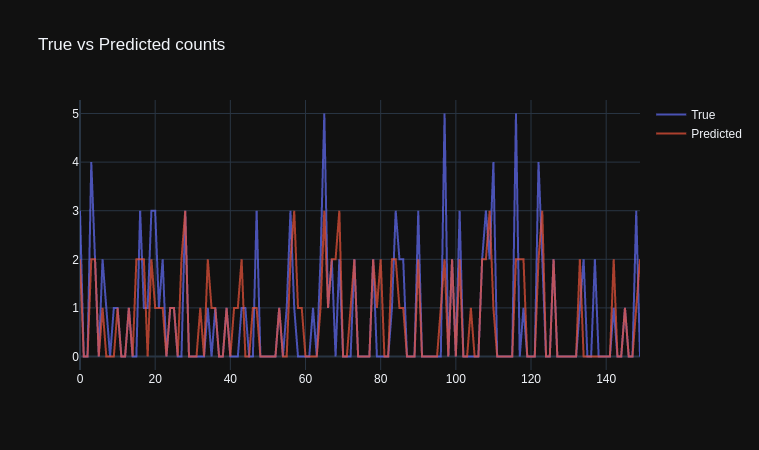

{'total_samples': 1035, 'total_abs_error': 595, 'total_corr_samples': 610, 'acc': 0.59, 'acc_not_zero_count': 0.33, 'mae': 0.57, 'mse': 0.97}


In [135]:
analyse_error(y_test, y_pred_rounded, 'Random Forest')
print(error_tracker['Random Forest'])

### Verify scores with cross validation

Verify if the result above was obtained due to the random data split, and train on the whole data using Cross Validation folds.

In [142]:
# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = RandomForestRegressor(n_estimators=300, criterion='mse', n_jobs=6)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))


mean mse: 0.9717391304347827
mean mae: 0.5717391304347827


#### Commentary

As can be observed in the Cross Validation scores, the model works as per the train/test results.

### Test Neural Network approach

I have tested many variations of the Feed Forward Neural Network.

The best performing (and also fitting the purpose) turned out to be a simple Network with only two 6-neuron hidden layers and a Dropout layer of rate 0.1 to a slight prevent overfitting, which was occurring.

Increasing model's complexity results in overfitting, as we only have ~3,100 data points in the training sample. As seen in the model summary below, the model has 199 trainable parameters. According to the best practices in Deep Learning, where we should always have 10x more data samples than parameters in the model - this model is not breaching this rule.

Activation functions have been chosen carefully to fit the purpose:
- hidden layers use **relu** (as a standard in modern neural network hidden layers)
- output layer uses **exponential** (as outputs should not be negative and it's used for modelling count data)

Lowering learning rate resulted in a much more smooth loss curve.

Training the model for 40 epochs with a batch size of 16 was the sweet spot to achieve the best convergence.

The predictions generated by the model had to be rounded to the nearest integer, as we are modelling the count data (which should not be a floating point type).

In [28]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.activations import exponential

In [151]:
# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])
y = raw_data['obs_count_corr']

# split into training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define layers
inputs = Input(shape=(X.shape[1],))
x = Dense(6, activation="relu")(inputs)
x = Dropout(0.1)(x)
x = Dense(6, activation="relu")(x)
outputs = Dense(1, activation="exponential")(x)
# Create model
model = Model(inputs=inputs, outputs=outputs, name="nn_reg_model")
opt = Adam(learning_rate=0.0013)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
model.summary()

Model: "nn_reg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 22)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 138       
_________________________________________________________________
dropout_20 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 7         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


mse: 0.9719806763285024
mae 0.5642512077294686


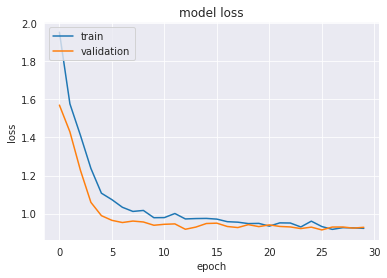

In [152]:
history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=16,
                    verbose=0, validation_data=(X_test_scaled, y_test))
# Predict and calculate stats
y_pred = model.predict(X_test_scaled)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test, y_pred_rounded))
print('mae', mean_absolute_error(y_test, y_pred_rounded))

# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Analysis:
- The validation loss curve is smooth, which indicates a good choice of learning rate
- There is no overfitting visible, as validation loss does not jump upwards
- Model converges after 30-40 epochs by minimising the mean squared error ($mse\approx0.98$)
- Model's performance varies slightly between the runs ($mae+-0.2$)

In [153]:
# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print(y_pred_rounded[:10].tolist())
print(y_test[:10].tolist())

[2, 0, 0, 2, 2, 0, 2, 0, 0, 1]
[3, 0, 0, 4, 2, 0, 2, 1, 0, 1]


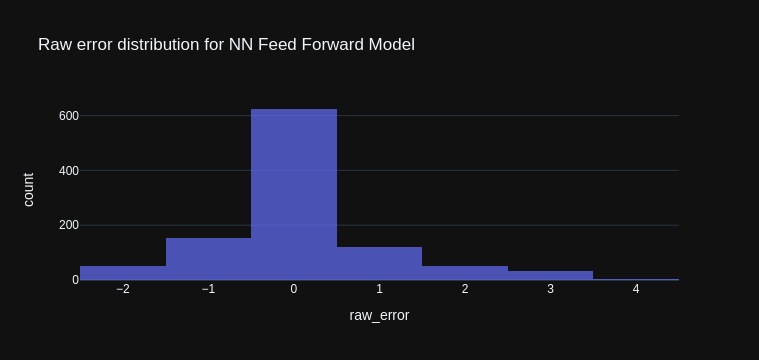

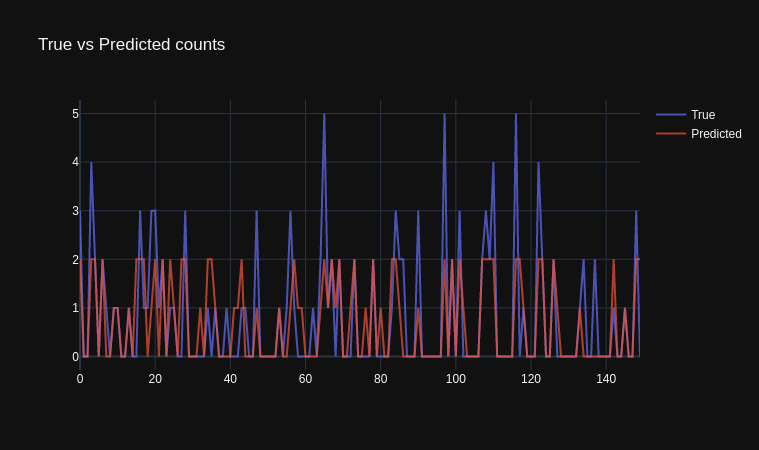

{'total_samples': 1035, 'total_abs_error': 584, 'total_corr_samples': 624, 'acc': 0.6, 'acc_not_zero_count': 0.34, 'mae': 0.56, 'mse': 0.97}


In [154]:
analyse_error(y_test, y_pred_rounded, 'NN Feed Forward')
print(error_tracker['NN Feed Forward'])

### Verify results with Cross Validation

In [155]:
# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    # Define layers
    inputs = Input(shape=(X.shape[1],))
    x = Dense(6, activation="relu")(inputs)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="relu")(x)
    outputs = Dense(1, activation="exponential")(x)
    # Create and fit the model and fit
    model = Model(inputs=inputs, outputs=outputs, name="nn_reg_model")
    opt = Adam(learning_rate=0.0013)
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=16,
                    verbose=0, validation_data=(X_test_scaled, y_test))
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))


mean mse: 0.98743961352657
mean mae: 0.5685990338164252


#### Commentary

The Cross Validation results are consistent with a single train split.

So far, in terms of Neural Networks - the **NN Feed Forward** model has the best error statistics. But the results are almost the same as the **Random Forests** model (only slightly better).

I have also tested a Neural Network with the Poisson family loss function (**Zero inflated Negative Bonomial**), which is used to model a distibution of count data dominated by zeros.

Inspired by an excellent implementation available [here in Colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb#scrollTo=FQFfRlKfLjUi), the results did not show any improvement over the simpler Feed Forward Network (at best they were 20% worse), so I have excluded it from this analysis.

### Multivariate LSTM Recurrent NN

In terms of forecasting and Neural Networks, a golden standard is the LSTM model.

It's actually the slowest model to train out of all the models I have tested, so with more time perhaps slightly better results can be achieved.

While it did not achieve a significantly better results then the simpler cousin - Feed Forward Neural Net, I am including the experiment due to the interesting and unique preprocessing of the inputs and that the model accuracy was indeed a little bit higher (0.63 vs 0.61 with Feed Forward NN).

First of all, due to the small size of training data, a very simple LSTM architecture was utilised with only 2 LSTM units and a 0.1 Droput layer to prevent serious overfitting. Even this simpe model generated already a 437 weights to keep track of.

How does it all work?

In order to feed a Recurrent Neural net we need to prepare a sequence of data points. Even though I did it manually up front, it turned out that Keras makes it very easy with its `TimeseriesGenerator` class.

What we need to think about is how many records do we include in a sequence, but this can be easily controlled by the `length` parameter. This is something, which is promising, but as of now a number of 4 has produced the most optimal results.

What's very important and also unique is the `shuffle=False` parameter in the call to the `fit` method. The chronological order of records is crucial and critical to RNNs to work.

The results were on par with the Feed Forward Network, but with additional data and time for experiments, it feels like the LSTM approach has a good potential to become the most accurate model (with a tradeoff of being also the slowest and resource-hungy one).

In [156]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional

In [157]:
# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])
y = raw_data['obs_count_corr']

# split into training/testing (without the shuffle as order is important here)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [158]:
BACKWARD_LAG = 5  # tune this parameter (study this parameter more!)
BATCH_SIZE = 32
data_gen_train = TimeseriesGenerator(X_train_scaled, y_train.to_numpy(),
                                     length=BACKWARD_LAG, batch_size=BATCH_SIZE)
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(),
                                    length=BACKWARD_LAG, batch_size=BATCH_SIZE)

In [159]:
model = Sequential()
model.add(Bidirectional(
    LSTM(2),
    input_shape=(BACKWARD_LAG, X_train_scaled.shape[1])
))
model.add(Dropout(0.1))
model.add(Dense(1))
opt = Adam(learning_rate=0.0012)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
history = model.fit(data_gen_train, epochs=45, verbose=0, validation_data=data_gen_test, shuffle=False)  # make sure Shuffle is off for RNNs

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4)                 400       
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 5         
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


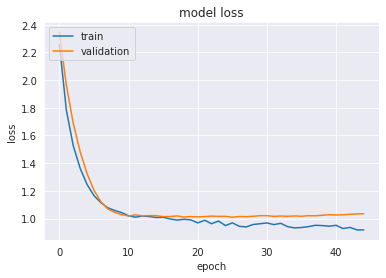

In [160]:
# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [161]:
# prepare test data
BATCH_SIZE = 1
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(), length=BACKWARD_LAG, batch_size=BATCH_SIZE)
X_test_rnn = []
y_test_rnn = []
for X, y in data_gen_test:
    X_test_rnn.append(X)
    y_test_rnn.append(y)
X_test_rnn = np.array(X_test_rnn)
y_test_rnn = np.array(y_test_rnn)
X_test_rnn = np.squeeze(X_test_rnn)  # remove the extra dimension (related to batch)
y_test_rnn = np.array([p[0] for p in y_test_rnn])

In [162]:
# Predict and calculate stats
y_pred = model.predict(X_test_rnn)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test_rnn, y_pred_rounded))
print('mae', mean_absolute_error(y_test_rnn, y_pred_rounded))

mse: 0.9631067961165048
mae 0.5475728155339806


In [163]:
# verify predictions versus the actual counts to make sure the predictions do make sense,
# for example model is not predicting high counts during the night or during the high gusts
print('pred:', y_pred_rounded[:20].tolist())
print('true:', y_test_rnn[:20].tolist())

pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 2]
true: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 4, 0, 4, 2, 3]


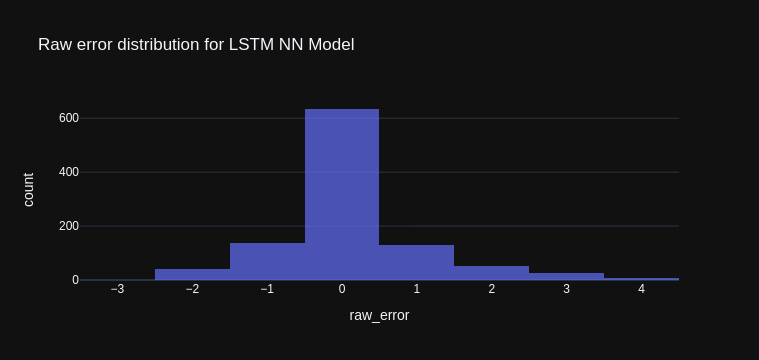

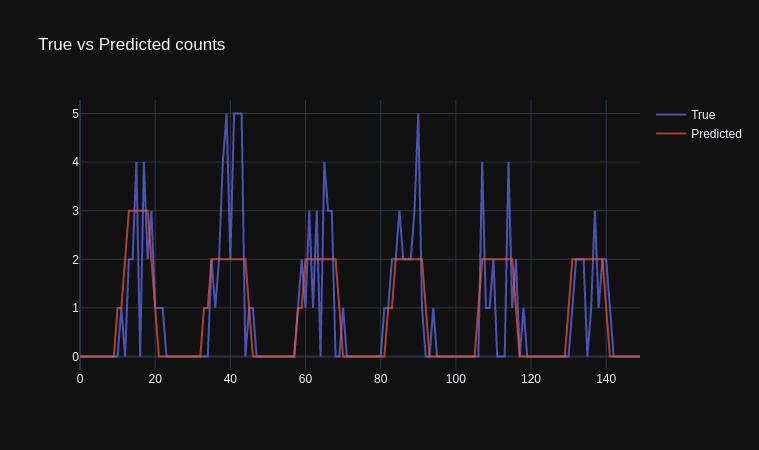

{'total_samples': 1030, 'total_abs_error': 564, 'total_corr_samples': 634, 'acc': 0.62, 'acc_not_zero_count': 0.32, 'mae': 0.55, 'mse': 0.96}


In [164]:
analyse_error(y_test_rnn, y_pred_rounded, 'LSTM NN')
print(error_tracker['LSTM NN'])

### Very results with Cross Validation

With the sequence model we can not perform a standard Cross Validation, as it would split the sequences for us, and we do not want that to happen.

What we can do instead is to generate a *flipped* train/test split, where we will take the first N observations as a test-set now (instead the last 25% with the sklearn train-test split).

In [171]:
# create dataset by merging all features
X = merge_datasets([numerical, dummies, cyclical])
y = raw_data['obs_count_corr']

# split into training/testing manually by taking the first N observations as a test-set now
break_point = 1000
X_test = X[:break_point]
y_test = y[:break_point]
X_train = X[break_point:]
y_train = y[break_point:]

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [172]:
BACKWARD_LAG = 5  # tune this parameter (study this parameter more!)
BATCH_SIZE = 32
data_gen_train = TimeseriesGenerator(X_train_scaled, y_train.to_numpy(),
                                     length=BACKWARD_LAG, batch_size=BATCH_SIZE)
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(),
                                    length=BACKWARD_LAG, batch_size=BATCH_SIZE)

In [173]:
model = Sequential()
model.add(Bidirectional(
    LSTM(2),
    input_shape=(BACKWARD_LAG, X_train_scaled.shape[1])
))
model.add(Dropout(0.1))
model.add(Dense(1))
opt = Adam(learning_rate=0.0012)
model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
history = model.fit(data_gen_train, epochs=45, verbose=0,
                    validation_data=data_gen_test, shuffle=False)  # make sure Shuffle is off for RNNs

  ...
    to  
  ['...']
  ...
    to  
  ['...']


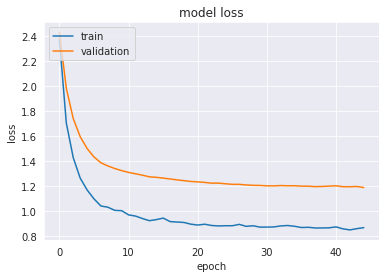

In [174]:
# Plot "Loss" over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [175]:
# prepare test data
BATCH_SIZE = 1
data_gen_test = TimeseriesGenerator(X_test_scaled, y_test.to_numpy(), length=BACKWARD_LAG,
                                    batch_size=BATCH_SIZE)
X_test_rnn = []
y_test_rnn = []
for X, y in data_gen_test:
    X_test_rnn.append(X)
    y_test_rnn.append(y)
X_test_rnn = np.array(X_test_rnn)
y_test_rnn = np.array(y_test_rnn)
X_test_rnn = np.squeeze(X_test_rnn)  # remove the extra dimension (related to batch)
y_test_rnn = np.array([p[0] for p in y_test_rnn])

In [176]:
# Predict and calculate stats
y_pred = model.predict(X_test_rnn)

# Round to nearest int and clip at 0 (no negatives are allowed)
y_pred_rounded = np.array([int(round(p[0])) for p in y_pred])

# Print scores
print('mse:', mean_squared_error(y_test_rnn, y_pred_rounded))
print('mae', mean_absolute_error(y_test_rnn, y_pred_rounded))

mse: 1.3115577889447236
mae 0.7105527638190955


#### Commentary

Suprisingly, this test resulted in the spike in errors. When trying multiple times, I've also noticed some symptoms or overfitting, and I have concluded that even though LSTM is a very powerful model, it most likely requires more data to perform at a satisfactory level and being robust.

### Overall stats for train/test splits

Here are the error statistics collected on the 25/75% train-test split across all models included in this Notebook.

I have tested many more models and tweaked hyperparameters of the existing models and I feel that there is still a little room for improvement with more time and patience on hand.

**So which model should be chosen here?**

Unfortunately, even though **LSTM model** shows the best results here, I wasn't happy enough with it's performance when the testing happened on the first 2% of the data and this model is very data hungry and slow to train, so based on these facts I would not choose it.

All the models show very little variability in the results, and as a result of that and the simplicity, speed and robustness of the deterministic **Simple Averages model**, it is a model of my choice for generating the forecast for the Count Data.

It is an interesting scenario where choosing a **Machine Learning model** might not be the most optimal choice.

In [178]:
error_df = pd.DataFrame(error_tracker).T.sort_values('mae', ascending=True)
error_df

,total_samples,total_abs_error,total_corr_samples,acc,acc_not_zero_count,mae,mse
LSTM NN,1030.0,564.0,634.0,0.62,0.32,0.55,0.96
NN Feed Forward,1035.0,584.0,624.0,0.60,0.34,0.56,0.97
Random Forest,1035.0,595.0,610.0,0.59,0.33,0.57,0.97
Simple Average,1035.0,613.0,618.0,0.60,0.33,0.59,1.05
Linear Regression,1035.0,641.0,575.0,0.56,0.40,0.62,1.05
